In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
TOTAL_ROWS = 10000

COLUMNS = [
    'electrode force',
    'electrode contact surface diameter',
    'squeeze time',
    'weld time',
    'hold time',
    'weld current',
    'leak rate',
    'explosive force',
    'leaking',
    'explosion'
]

INPUT_COLUMNS = [
    'electrode force',
    'electrode contact surface diameter',
    'squeeze time',
    'weld time',
    'hold time',
    'weld current'
]

OUTPUT_COLUMNS = [
    'leak rate',
    'explosive force',
    'leaking',
    'explosion'
]

CATEGORICAL_LABELS = ['leaking', 'explosion']

In [4]:
def generate_coefficients(input_length, output_length):
    mean = 0
    stddev = 5.0
    rows = input_length
    columns = output_length
    return np.random.normal(mean, stddev, size=(rows, columns))

def generate_row(coefficients):
    rows, columns = coefficients.shape
    input_row = np.random.rand(columns)
    output = np.matmul(coefficients, input_row)
    output = output.tolist()
    assert len(output) >= 4
    output[-2] = "leaking" if output[-4] > 0 else "not leaking"
    output[-1] = "explosion" if output[-3] > 0 else "no explosion"
    output = input_row.tolist() + output
    return output

def generate_sets(myset, output_columns, categorical_labels):
    myset_labels = myset[output_columns].copy()
    myset = myset.drop(output_columns, axis=1)
    myset_categorical = myset_labels[categorical_labels]
    categorical_encoder = OneHotEncoder()
    myset_categorical = categorical_encoder.fit_transform(myset_categorical)
    myset_categorical = myset_categorical.toarray()
    return myset, myset_labels, myset_categorical, categorical_encoder

In [5]:
my_dataframe = pd.DataFrame(columns=COLUMNS)
coefficients = generate_coefficients(len(INPUT_COLUMNS), len(OUTPUT_COLUMNS))
for i in range(TOTAL_ROWS):
    my_dataframe.loc[len(my_dataframe)] = generate_row(coefficients)
print(my_dataframe.head())

   electrode force  electrode contact surface diameter  squeeze time  \
0         0.845414                            0.333774      0.457253   
1         0.924608                            0.378278      0.168732   
2         0.518913                            0.094494      0.132893   
3         0.329708                            0.704279      0.418995   
4         0.989700                            0.933375      0.119256   

   weld time  hold time  weld current  leak rate  explosive force  \
0   0.106281  -9.020655      0.243048  -2.831844        -4.385680   
1   0.262312  -8.335358     -0.532591  -1.583722        -4.862011   
2   0.756861  -5.750594      0.545010  -2.480618        -7.880316   
3   0.997765 -10.396823     -1.252551  -1.252645        -5.859409   
4   0.421598 -11.777516     -2.825007   0.677915        -2.963699   

       leaking     explosion  
0  not leaking  no explosion  
1  not leaking  no explosion  
2  not leaking  no explosion  
3  not leaking  no explosion

In [6]:
X_train, X_test = train_test_split(my_dataframe, test_size=0.2, random_state=42)
X_train, X_validation = train_test_split(X_train)

X_train_labels = X_train[OUTPUT_COLUMNS].copy()
X_train = X_train.drop(OUTPUT_COLUMNS, axis=1)
X_train_categorical = X_train_labels[CATEGORICAL_LABELS]
X_train_labels = X_train_labels.drop(CATEGORICAL_LABELS, axis=1)
train_categorical_encoder = OneHotEncoder()
X_train_categorical = train_categorical_encoder.fit_transform(X_train_categorical)
X_train_categorical = X_train_categorical.toarray()

X_test_labels = X_test[OUTPUT_COLUMNS].copy()
X_test = X_test.drop(OUTPUT_COLUMNS, axis=1)
X_test_categorical = X_test_labels[CATEGORICAL_LABELS]
X_test_labels = X_test_labels.drop(CATEGORICAL_LABELS, axis=1)
test_categorical_encoder = OneHotEncoder()
X_test_categorical = test_categorical_encoder.fit_transform(X_test_categorical)
X_test_categorical = X_test_categorical.toarray()

X_validation_labels = X_validation[OUTPUT_COLUMNS].copy()
X_validation = X_validation.drop(OUTPUT_COLUMNS, axis=1)
X_validation_categorical = X_validation_labels[CATEGORICAL_LABELS]
X_validation_labels = X_validation_labels.drop(CATEGORICAL_LABELS, axis=1)
validation_categorical_encoder = OneHotEncoder()
X_validation_categorical = validation_categorical_encoder.fit_transform(X_validation_categorical)
X_validation_categorical = X_validation_categorical.toarray()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

print(X_train_categorical[:10])
print(train_categorical_encoder.categories_)

[[0. 1. 0. 1.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]]
[array(['leaking', 'not leaking'], dtype=object), array(['explosion', 'no explosion'], dtype=object)]


In [7]:
y_train_regression = X_train_labels
y_train_classification = X_train_categorical
y_test_regression = X_test_labels
y_test_classification = X_test_categorical
y_validation_regression = X_validation_labels
y_validation_classification = X_validation_categorical

y_train = y_train_regression
y_test = y_test_regression
y_validation = y_validation_regression

In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
INPUT_WIDTH = len(INPUT_COLUMNS)
OUTPUT_WIDTH = len(OUTPUT_COLUMNS)
numerical_output_width = y_train.shape[1]
categorical_output_width = y_train_classification.shape[1]

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(INPUT_WIDTH,)))
model.add(keras.layers.Dense(INPUT_WIDTH * 10, activation="relu"))
model.add(keras.layers.Dense(INPUT_WIDTH * 5, activation="relu"))
model.add(keras.layers.Dense(INPUT_WIDTH * 1, activation="relu"))
#model.add(keras.layers.Dense(numerical_output_width, activation="softmax"))
model.add(keras.layers.Dense(numerical_output_width))
#model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.compile(loss="mse", optimizer="adam", metrics=["mse"])
history = model.fit(X_train,
    y_train,
    epochs=30,
    validation_data=(X_validation, y_validation))
mse_test = model.evaluate(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10.9374 - mse: 10.9374 - val_loss: 0.2999 - val_mse: 0.2999
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2185 - mse: 0.2185 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

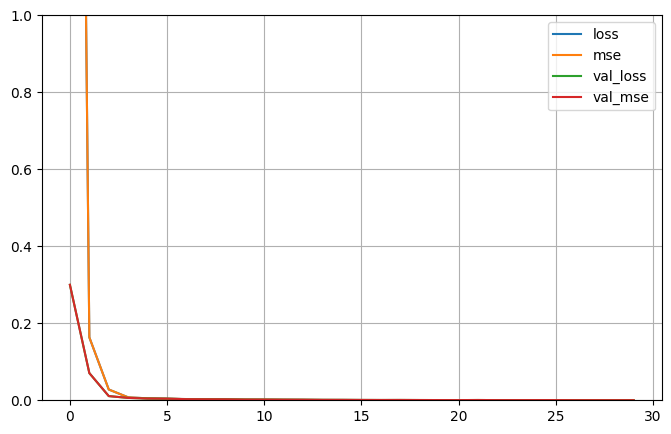

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [12]:
y_prediction = model.predict(X_test)
print(y_prediction[:10])

model_filename = "my_model.h5"
print("Saving " + model_filename)
#model.save(model_filename)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[-1.7279025  -5.720717  ]
 [-0.60120785 -0.23924595]
 [-2.2790518  -4.3820143 ]
 [-1.8675113  -5.5146804 ]
 [-1.2214359  -5.1327276 ]
 [-2.1415796  -5.3059187 ]
 [-1.7628696  -3.0466843 ]
 [ 2.1405315   1.7555257 ]
 [-1.765573   -4.9130616 ]
 [-4.576766   -5.129072  ]]
Saving my_model.h5


In [37]:
x = X_test[:1]
print(x)
print(model.predict(x))

[[-1.47356503 -1.45189101 -1.19292382  0.85500674  2.06712595  0.55251785]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
[[-1.7279022 -5.7207155]]


In [43]:
def f(x):
    return model.predict(x)

def newton_step(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)  # y: (1, output_dim)
    J = tape.jacobian(y, x)  # J: (1, output_dim, 1, input_dim)

    # Remove batch dimensions
    J = tf.squeeze(J, axis=[0, 2])  # Now J: (output_dim, input_dim)
    y = tf.squeeze(y, axis=0)       # y: (output_dim,)

    JT = tf.transpose(J)            # JT: (input_dim, output_dim)
    JTJ = tf.matmul(JT, J)          # JTJ: (input_dim, input_dim)
    JTf = tf.matmul(JT, tf.expand_dims(y, axis=1))  # JTf: (input_dim, 1)

    delta = tf.linalg.solve(JTJ, JTf)  # delta: (input_dim, 1)
    return x - tf.transpose(delta)     # Make sure delta is (1, input_dim)

def gauss_newton(x, number_iterations = 20):
    x = tf.Variable(x, dtype=tf.float32)
    for i in range(number_iterations):
        fx = f(x)
        loss = tf.reduce_sum(fx**2)
        print(f"Step {i}, x = {x.numpy()}, loss = {loss.numpy():.6f}")
        x.assign(newton_step(x))

    return x.numpy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Step 0, x = [[-1.473565   -1.4518911  -1.1929238   0.85500675  2.067126    0.55251783]], loss = 35.712231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Step 1, x = [[10.519119  -4.656021  -4.0653934 -8.897524  38.054985  10.772407 ]], loss = 468.076416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Step 2, x = [[ -13.980377   -6.005877  -90.6789    126.78233  -398.85248    18.0744  ]], loss = 131881.593750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Step 3, x = [[ -1.3834801 653.413      14.048355  266.4187    -73.0343    436.98352  ]], loss = 7761.301758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Step 4, x = [[ -23.13591   647.3643     49.932747  220.54587  -161.82043   453.261   ]], loss = 14.029476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Step 5, x = [[ -24.488163  647.27606    46.861317  220.37444  -164.04901   452.88956 ]], loss = 0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Step 6, x = [[ -24.488197  647.2761     46.86126   220.37442  -164.04913   452.88968 ]], loss = 0.

In [44]:
x = gauss_newton(X_test[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Step 0, x = [[-1.473565   -1.4518911  -1.1929238   0.85500675  2.067126    0.55251783]], loss = 35.712231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Step 1, x = [[10.519119  -4.656021  -4.0653934 -8.897524  38.054985  10.772407 ]], loss = 468.076416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Step 2, x = [[ -13.980377   -6.005877  -90.6789    126.78233  -398.85248    18.0744  ]], loss = 131881.593750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Step 3, x = [[ -1.3834801 653.413      14.048355  266.4187    -73.0343    436.98352  ]], loss = 7761.301758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Step 4, x = [[ -23.13591   647.3643     49.932747  220.54587  -161.82043   453.261   ]], loss = 14.029476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Step 5, x = [[ -24.488163  647.27606    46.861317  220.37444  -164.04901   452.88956 ]], loss = 0.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Step 6, x = [[ -24.488197  647.2761     46.86126   220.37442  -164.04913   452.88968 ]], loss = 0.